In [1]:
import keras 
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import string
import re
import matplotlib.pyplot as plt

## Load txt files

In [2]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(directory="/home/jupyter-ozkan_ma/data/TXT/Full_Experiment/train/",
                                                          labels="inferred",
                                                          label_mode="categorical",
                                                          batch_size=64,
                                                          validation_split=0.2,
                                                          subset="training",        
                                                          seed=1337)

Found 60000 files belonging to 5 classes.
Using 48000 files for training.


In [3]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(directory="/home/jupyter-ozkan_ma/data/TXT/Full_Experiment/train/",
                                                          labels="inferred",
                                                          label_mode="categorical",
                                                          batch_size=64,
                                                          validation_split=0.2,
                                                          subset="validation",
                                                          seed=1337)

Found 60000 files belonging to 5 classes.
Using 12000 files for validation.


In [4]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(directory="/home/jupyter-ozkan_ma/data/TXT/Full_Experiment/test/",
                                                         labels="inferred",
                                                         label_mode="categorical",
                                                         batch_size=64)

Found 15000 files belonging to 5 classes.


### Model Constants

In [5]:
max_features = 30000
embedding_dim = 128
sequence_length = 512
epochs=10

### Text Vectorizer

In [6]:
vectorize_layer = TextVectorization(max_tokens=max_features,
                                    standardize="lower_and_strip_punctuation",
                                    output_mode="int",
                                    output_sequence_length=sequence_length)

In [7]:
c

In [8]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Function to plotting accuracy and loss

In [9]:
def plot_train_val_loss(epochs, loss, val_loss):
    
    plt.clf()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [10]:
def plot_train_val_acc(epochs, acc, val_acc):
    
    plt.clf()   # clear figure

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Function to compile and train model, evaluate its performance on the test set

In [11]:
def run_model(input_layer, output_layer, train_data, val_data, test_data):
    
    model = tf.keras.Model(input_layer, output_layer)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    print("Training of the model: \n")
    model_history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callback)
    
    print("Performance of the model to unseen data: \n")
    model.evaluate(test_data)
    
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_x = range(1, len(acc) + 1)
    
    plot_train_val_acc(epochs_x, acc, val_acc)
    plot_train_val_loss(epochs_x, loss, val_loss)

## Core layers and arguments for reusing

In [12]:
# A integer input for vocab indices.
input_layer = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
embedding_layer = Embedding(max_features, embedding_dim)(input_layer)

# We project onto five unit output layer, and squash it with a softmax:
# output_layer = Dense(5, activation="softmax", name="predictions")

In [13]:
callback = EarlyStopping(monitor="val_loss", patience=2)

## 9. Model: mod_09

In [14]:
mod09_lay01 = Dropout(0.5)(embedding_layer)
mod09_lay02 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(mod09_lay01)
mod09_lay03 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(mod09_lay02)
mod09_lay04 = GlobalMaxPooling1D()(mod09_lay03)
mod09_lay05 = Dense(128, activation="relu")(mod09_lay04)
mod09_lay06 = Dropout(0.5)(mod09_lay05)

mod09_outputLayer = Dense(5, activation="softmax")(mod09_lay06)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 11s 15ms/step - loss: 1.3821 - accuracy: 0.3924 - val_loss: 1.0212 - val_accuracy: 0.6028
Epoch 2/10
750/750 [==============================] - 4s 6ms/step - loss: 0.9001 - accuracy: 0.6660 - val_loss: 0.8813 - val_accuracy: 0.6659
Epoch 3/10
750/750 [==============================] - 4s 6ms/step - loss: 0.6317 - accuracy: 0.7769 - val_loss: 0.9186 - val_accuracy: 0.6877
Epoch 4/10
750/750 [==============================] - 4s 6ms/step - loss: 0.4510 - accuracy: 0.8459 - val_loss: 1.0377 - val_accuracy: 0.6958
Performance of the model to unseen data: 

235/235 [==============================] - 4s 17ms/step - loss: 1.0424 - accuracy: 0.7019


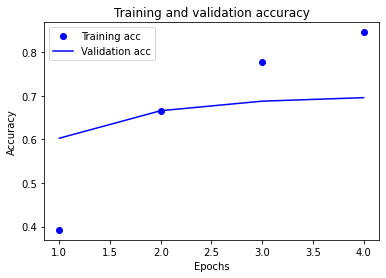

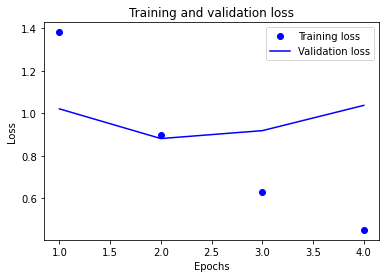

In [15]:
run_model(input_layer, mod09_outputLayer, train_ds, val_ds,test_ds)

## 10. Model: mod_10

In [16]:
mod10_lay01 = GlobalMaxPooling1D()(embedding_layer)
mod10_lay02 = Dense(64, activation="relu")(mod10_lay01)
mod10_lay03 = Dense(32, activation="relu")(mod10_lay02)      
mod10_lay04 = Dense(16, activation="relu")(mod10_lay03)

mod10_outputLayer = Dense(5, activation="softmax")(mod10_lay04)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 1.0405 - accuracy: 0.5990 - val_loss: 0.8587 - val_accuracy: 0.6813
Epoch 2/10
750/750 [==============================] - 4s 6ms/step - loss: 0.6148 - accuracy: 0.7782 - val_loss: 0.8969 - val_accuracy: 0.6872
Epoch 3/10
750/750 [==============================] - 5s 7ms/step - loss: 0.4242 - accuracy: 0.8529 - val_loss: 1.0077 - val_accuracy: 0.6886
Performance of the model to unseen data: 

235/235 [==============================] - 1s 4ms/step - loss: 1.0108 - accuracy: 0.6929


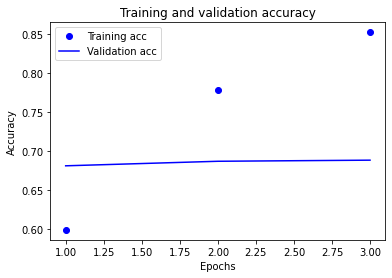

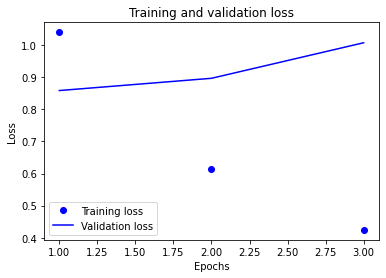

In [17]:
run_model(input_layer, mod10_outputLayer, train_ds, val_ds,test_ds)

## 11. Model: mod_11

In [18]:
mod11_lay01 = Dropout(0.5)(embedding_layer)
mod11_lay02 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(mod11_lay01)
mod11_lay03 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(mod11_lay02)
mod11_lay04 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(mod11_lay03)
mod11_lay05 = GlobalMaxPooling1D()(mod11_lay04)

mod11_outputLayer = Dense(5, activation="softmax")(mod11_lay05)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 9s 12ms/step - loss: 0.6131 - accuracy: 0.7674 - val_loss: 0.9768 - val_accuracy: 0.6898
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3055 - accuracy: 0.8941 - val_loss: 1.1574 - val_accuracy: 0.6967
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.2259 - accuracy: 0.9227 - val_loss: 1.3565 - val_accuracy: 0.6969
Performance of the model to unseen data: 

235/235 [==============================] - 2s 8ms/step - loss: 1.3674 - accuracy: 0.6942


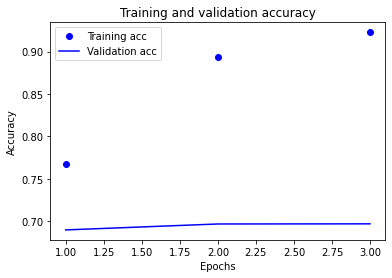

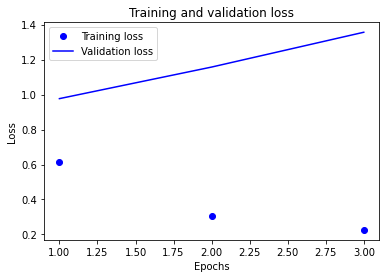

In [19]:
run_model(input_layer, mod11_outputLayer, train_ds, val_ds,test_ds)

## 12. Model: mod_12

In [20]:
mod12_lay01 = GRU(128)(embedding_layer)
mod12_lay02 = Dense(64, activation="relu")(mod12_lay01)
mod12_lay03 = Dense(16, activation="relu")(mod12_lay02)

mod12_outputLayer = Dense(5, activation="softmax")(mod12_lay03)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 26s 34ms/step - loss: 1.6101 - accuracy: 0.1999 - val_loss: 1.6095 - val_accuracy: 0.1986
Epoch 2/10
750/750 [==============================] - 25s 33ms/step - loss: 1.6096 - accuracy: 0.1978 - val_loss: 1.6095 - val_accuracy: 0.1992
Epoch 3/10
750/750 [==============================] - 25s 34ms/step - loss: 1.6086 - accuracy: 0.1997 - val_loss: 1.6088 - val_accuracy: 0.1977
Epoch 4/10
750/750 [==============================] - 25s 34ms/step - loss: 1.5993 - accuracy: 0.2027 - val_loss: 1.5943 - val_accuracy: 0.2073
Epoch 5/10
750/750 [==============================] - 26s 34ms/step - loss: 1.5568 - accuracy: 0.2467 - val_loss: 1.4220 - val_accuracy: 0.3907
Epoch 6/10
750/750 [==============================] - 25s 34ms/step - loss: 0.8335 - accuracy: 0.6795 - val_loss: 0.8842 - val_accuracy: 0.6899
Epoch 7/10
750/750 [==============================] - 25s 34ms/step - loss: 0.3902 - accuracy: 0.8672 - val_los

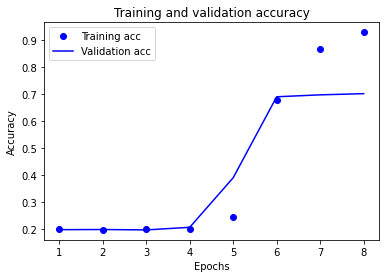

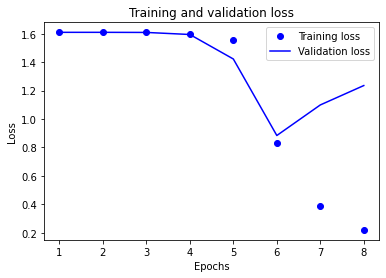

In [21]:
run_model(input_layer, mod12_outputLayer, train_ds, val_ds,test_ds)

## 13. Model: mod_13

In [24]:
mod13_lay01 = Bidirectional(GRU(128, return_sequences=True))(embedding_layer)
mod13_lay02 = Bidirectional(GRU(64, return_sequences=True))(mod13_lay01)
mod13_lay03 = Bidirectional(GRU(16))(mod13_lay02)

mod13_outputLayer = Dense(5, activation="softmax")(mod13_lay03)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 135s 181ms/step - loss: 0.5636 - accuracy: 0.7984 - val_loss: 1.1247 - val_accuracy: 0.6820
Epoch 2/10
750/750 [==============================] - 134s 179ms/step - loss: 0.1879 - accuracy: 0.9410 - val_loss: 1.2858 - val_accuracy: 0.6913
Epoch 3/10
750/750 [==============================] - 135s 179ms/step - loss: 0.1325 - accuracy: 0.9594 - val_loss: 1.4000 - val_accuracy: 0.6852
Performance of the model to unseen data: 

235/235 [==============================] - 16s 67ms/step - loss: 1.3563 - accuracy: 0.6921


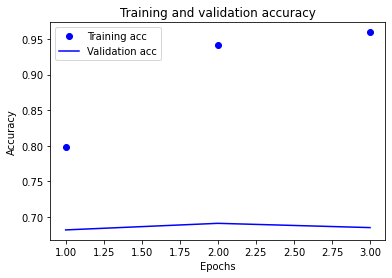

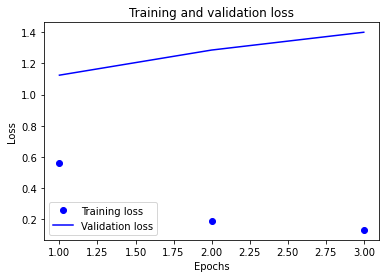

In [25]:
run_model(input_layer, mod13_outputLayer, train_ds, val_ds,test_ds)

## 14. Model: mod_14

In [26]:
mod14_lay01 = LSTM(148)(embedding_layer)
mod14_lay02 = Dense(64, activation="relu")(mod14_lay01)
mod14_lay03 = Dense(16, activation="relu")(mod14_lay02)

mod14_outputLayer = Dense(5, activation="softmax")(mod14_lay03)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 30s 40ms/step - loss: 1.6105 - accuracy: 0.1986 - val_loss: 1.6096 - val_accuracy: 0.1986
Epoch 2/10
750/750 [==============================] - 32s 43ms/step - loss: 1.6095 - accuracy: 0.1956 - val_loss: 1.6095 - val_accuracy: 0.1969
Epoch 3/10
750/750 [==============================] - 31s 41ms/step - loss: 1.6097 - accuracy: 0.1984 - val_loss: 1.6142 - val_accuracy: 0.2036
Epoch 4/10
750/750 [==============================] - 32s 43ms/step - loss: 1.6095 - accuracy: 0.2021 - val_loss: 1.6093 - val_accuracy: 0.2004
Epoch 5/10
750/750 [==============================] - 31s 42ms/step - loss: 1.5943 - accuracy: 0.2314 - val_loss: 1.5424 - val_accuracy: 0.2975
Epoch 6/10
750/750 [==============================] - 32s 42ms/step - loss: 1.3547 - accuracy: 0.4022 - val_loss: 1.3731 - val_accuracy: 0.4241
Epoch 7/10
750/750 [==============================] - 32s 42ms/step - loss: 1.0041 - accuracy: 0.5641 - val_los

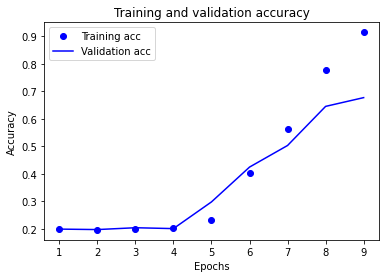

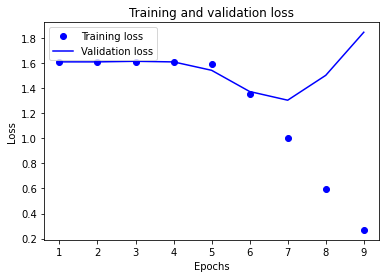

In [27]:
run_model(input_layer, mod14_outputLayer, train_ds, val_ds,test_ds)

## 15. Model: mod_15

In [28]:
mod15_lay01 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
mod15_lay02 = Bidirectional(LSTM(64, return_sequences=True))(mod15_lay01)
mod15_lay03 = Bidirectional(LSTM(16))(mod15_lay02)

mod15_outputLayer = Dense(5, activation="softmax")(mod15_lay03)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 140s 186ms/step - loss: 1.0784 - accuracy: 0.5934 - val_loss: 1.1530 - val_accuracy: 0.5743
Epoch 2/10
750/750 [==============================] - 128s 171ms/step - loss: 0.4525 - accuracy: 0.8487 - val_loss: 1.1304 - val_accuracy: 0.6785
Epoch 3/10
750/750 [==============================] - 134s 178ms/step - loss: 0.1820 - accuracy: 0.9441 - val_loss: 1.3977 - val_accuracy: 0.6701
Epoch 4/10
750/750 [==============================] - 137s 183ms/step - loss: 0.1293 - accuracy: 0.9615 - val_loss: 1.4594 - val_accuracy: 0.6855
Performance of the model to unseen data: 

235/235 [==============================] - 17s 74ms/step - loss: 1.4378 - accuracy: 0.6883


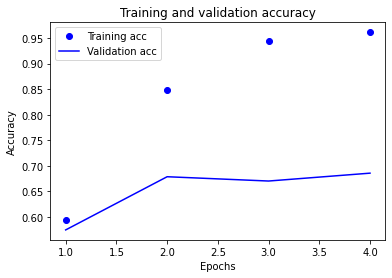

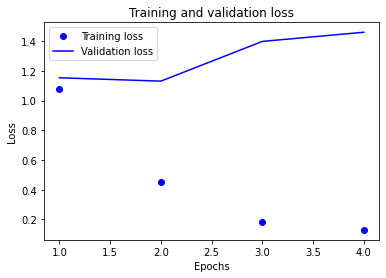

In [29]:
run_model(input_layer, mod15_outputLayer, train_ds, val_ds,test_ds)

## 16. Model: mod_16

In [30]:
mod16_lay01 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(embedding_layer)
mod16_lay02 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(mod16_lay01)
mod16_lay03 = Bidirectional(LSTM(128, return_sequences=True, go_backwards=True))(mod16_lay02)
mod16_lay04 = Bidirectional(LSTM(64))(mod16_lay03)
mod16_lay05 = Dense(16, activation="relu")(mod16_lay04)

mod16_outputLayer = Dense(5, activation="softmax")(mod16_lay05)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 24s 33ms/step - loss: 0.4806 - accuracy: 0.8149 - val_loss: 1.3132 - val_accuracy: 0.6718
Epoch 2/10
750/750 [==============================] - 24s 31ms/step - loss: 0.1282 - accuracy: 0.9582 - val_loss: 1.5633 - val_accuracy: 0.6586
Epoch 3/10
750/750 [==============================] - 23s 31ms/step - loss: 0.0809 - accuracy: 0.9746 - val_loss: 1.6664 - val_accuracy: 0.6776
Performance of the model to unseen data: 

235/235 [==============================] - 3s 14ms/step - loss: 1.6305 - accuracy: 0.6812


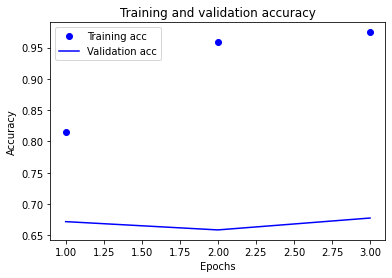

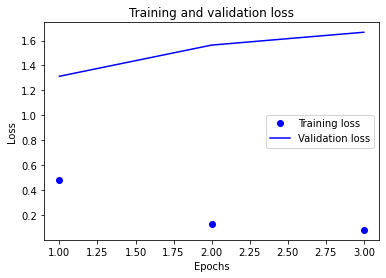

In [31]:
run_model(input_layer, mod16_outputLayer, train_ds, val_ds,test_ds)